In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

from tqdm import tqdm

In [2]:
### Load for warping to JRC space ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed = ants.resample_image(fixed,(256,128,49),1,interp_type=1) #nearest neighbor
#fixed = ants.resample_image(fixed,res_LUKE,0,0)

affine_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke-to-jrc2018_fwdtransforms_lowres/tmps47el_wi0GenericAffine.mat"

In [3]:
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke_lowres.nii"
luke = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke = ants.from_numpy(luke)
#res_LUKE = (0.65, 0.65, 1)
#luke.set_spacing(res_LUKE)

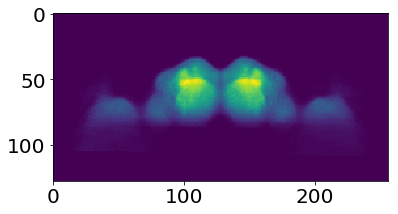

In [4]:
plt.imshow(luke.numpy()[:,:,9].T)

In [6]:
filter_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters'
os.listdir(filter_file)

['20210616_filters_rot.npy',
 '20210614_clusters_to_rotate.npy',
 '20210613_filters_voxel_res.npy',
 '20210613_filters_voxel_res_rot.npy',
 '20210618_filters_voxel_res.npy',
 'clustering',
 '20210613_filters.npy',
 '20210618_filters_fwd.npy']

In [7]:
filter_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210613_filters.npy'
filters = np.load(filter_file)
print(filters.shape)

n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

(49, 2000, 50)


In [ ]:
# ### normalize
# maxs = np.max(np.abs(filters),axis=-1)
# filters = filters/maxs[:,:,np.newaxis]
# filters.shape

In [ ]:
# ### can remove low responding voxels if desired

# filters = np.reshape(filters,(49*2000,50))

# all_maxs = np.max(np.abs(filters),axis=-1)
# threshold = np.percentile(all_maxs,75)
# peaks = np.argmax(filters,axis=-1)

# to_delete = np.where(all_maxs<threshold)[0]

# thresholded_filters = np.delete(filters, to_delete,axis=0)
# peaks = np.argmax(thresholded_filters,axis=-1)
# idx_sort = np.argsort(peaks)

# all_maxs = np.max(np.abs(thresholded_filters),axis=-1)
# thresholded_filters_norm = thresholded_filters/all_maxs[:,np.newaxis]
# print(thresholded_filters_norm.shape)

# add_deleted_voxels = np.zeros((49*2000,50))
# to_replace = [i for i in range(49*2000) if i not in to_delete]
# add_deleted_voxels[to_replace,:] = thresholded_filters_norm
# add_deleted_voxels.shape

# add_deleted_voxels = np.reshape(add_deleted_voxels,(49,2000,50))

In [10]:
filters.shape

(49, 2000, 30)

In [11]:
images = []
for tp in tqdm(range(30)):
    all_z = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            if len(cluster_indicies) > 200:
                colored_by_betas[cluster_indicies] = 0
            else:
                colored_by_betas[cluster_indicies] = filters[z,cluster_num,tp]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_z.append(colored_by_betas)
    all_z = np.asarray(all_z)
    images.append(all_z)
images = np.asarray(images)





  0%|          | 0/30 [00:00<?, ?it/s]



  3%|▎         | 1/30 [00:01<00:52,  1.81s/it]



  7%|▋         | 2/30 [00:03<00:50,  1.79s/it]



 10%|█         | 3/30 [00:05<00:48,  1.78s/it]



 13%|█▎        | 4/30 [00:07<00:46,  1.77s/it]



 17%|█▋        | 5/30 [00:08<00:44,  1.78s/it]



 20%|██        | 6/30 [00:10<00:42,  1.79s/it]



 23%|██▎       | 7/30 [00:12<00:40,  1.78s/it]



 27%|██▋       | 8/30 [00:14<00:39,  1.77s/it]



 30%|███       | 9/30 [00:15<00:37,  1.77s/it]



 33%|███▎      | 10/30 [00:17<00:35,  1.77s/it]



 37%|███▋      | 11/30 [00:19<00:33,  1.77s/it]



 40%|████      | 12/30 [00:21<00:31,  1.76s/it]



 43%|████▎     | 13/30 [00:22<00:29,  1.76s/it]



 47%|████▋     | 14/30 [00:24<00:28,  1.76s/it]



 50%|█████     | 15/30 [00:26<00:26,  1.76s/it]



 53%|█████▎    | 16/30 [00:28<00:24,  1.76s/it]



 57%|█████▋    | 17/30 [00:30<00:22,  1.76s/it]



 60%|██████    | 18/30 [00:31<00:21,  1.76s/it]



 63%|██████▎   | 19/30 [00:33<00:19,  1.77s/i

In [14]:
images.shape

(30, 49, 256, 128)

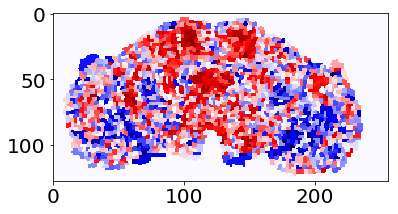

In [15]:
plt.imshow(images[15,20,:,:].T,cmap='seismic')#,vmax=1,vmin=-1)

In [16]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210618_filters_voxel_res.npy'
np.save(save_file, images)

In [8]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210613_filters_voxel_res.npy'
images = np.load(load_file)

In [9]:
print(images.shape)
images_ = np.moveaxis(images,1,3)
print(images_.shape)
images_ = np.moveaxis(images_,0,3)
print(images_.shape)

(50, 49, 256, 128)
(50, 256, 128, 49)
(256, 128, 49, 50)


In [10]:
res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(images_[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [11]:
maps = ants.apply_transforms(fixed, moving, affine_file, imagetype=3, interpolator='nearestNeighbor')

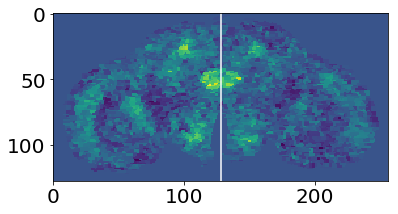

In [13]:
plt.imshow(maps.numpy()[:,:,27,25].T)
plt.axvline(128,color='white')

# Mirror Cleaning

In [14]:
maps = maps.numpy()

In [15]:
left = maps[:128,:,:,:]
right = maps[128:,:,:,:]

right = right[::-1,:,:,:]

In [16]:
left.shape

(128, 128, 49, 50)

In [17]:
### spatial smoothing if desired
# quick and dirty - should remove temporal axis and probably rescale z
left = gaussian_filter(left,sigma=2,truncate=1)
right = gaussian_filter(right,sigma=2,truncate=1)

In [18]:
corrs = []
sigs = []
for z in range(49):
    for x in range(128):
        for y in range(128):
            r, p = scipy.stats.pearsonr(left[x,y,z,:], right[x,y,z,:])
            corrs.append(r)
            sigs.append(p)
corrs = np.asarray(corrs)
sigs = np.asarray(sigs)

In [19]:
corrs_ = np.reshape(corrs,(49,128,128))
sigs_ = np.reshape(sigs,(49,128,128))

In [20]:
left_maxs = np.max(np.abs(left),axis=-1)
right_maxs = np.max(np.abs(right),axis=-1)

(-0.5, 127.5, 127.5, -0.5)

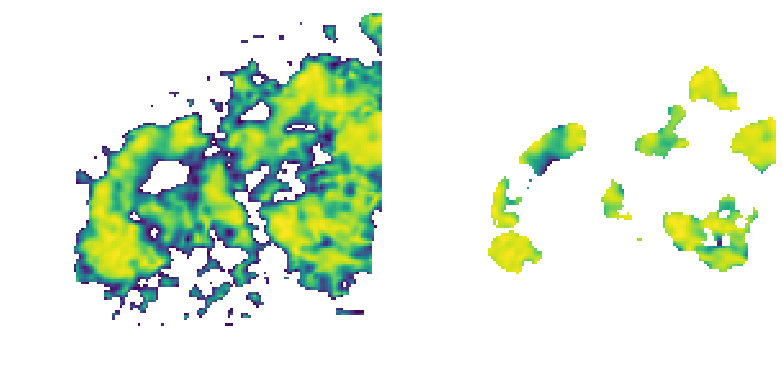

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(131)
corrs__ = corrs_.copy()
corrs__[np.where(corrs_<.5)]=np.nan
plt.imshow(corrs__[27,:,:].T)
plt.axis('off')

plt.subplot(132)
corrs__ = corrs_.copy()
corrs__[np.where(corrs_<.5)]=np.nan
corrs__[np.where(np.moveaxis(right_maxs,-1,0)<.0005)] = np.nan
corrs__[np.where(np.moveaxis(left_maxs,-1,0)<.0005)] = np.nan
plt.imshow(corrs__[27,:,:].T)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

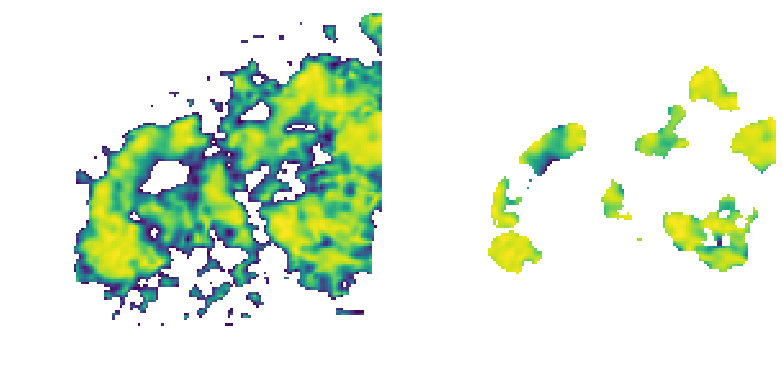

In [19]:
plt.figure(figsize=(20,10))

plt.subplot(131)
corrs__ = corrs_.copy()
corrs__[np.where(corrs_<.5)]=np.nan
plt.imshow(corrs__[27,:,:].T)
plt.axis('off')

plt.subplot(132)
corrs__ = corrs_.copy()
corrs__[np.where(corrs_<.5)]=np.nan
corrs__[np.where(np.moveaxis(right_maxs,-1,0)<.0005)] = np.nan
corrs__[np.where(np.moveaxis(left_maxs,-1,0)<.0005)] = np.nan
plt.imshow(corrs__[27,:,:].T)
plt.axis('off')

In [20]:
corrs_.shape

(49, 128, 128)

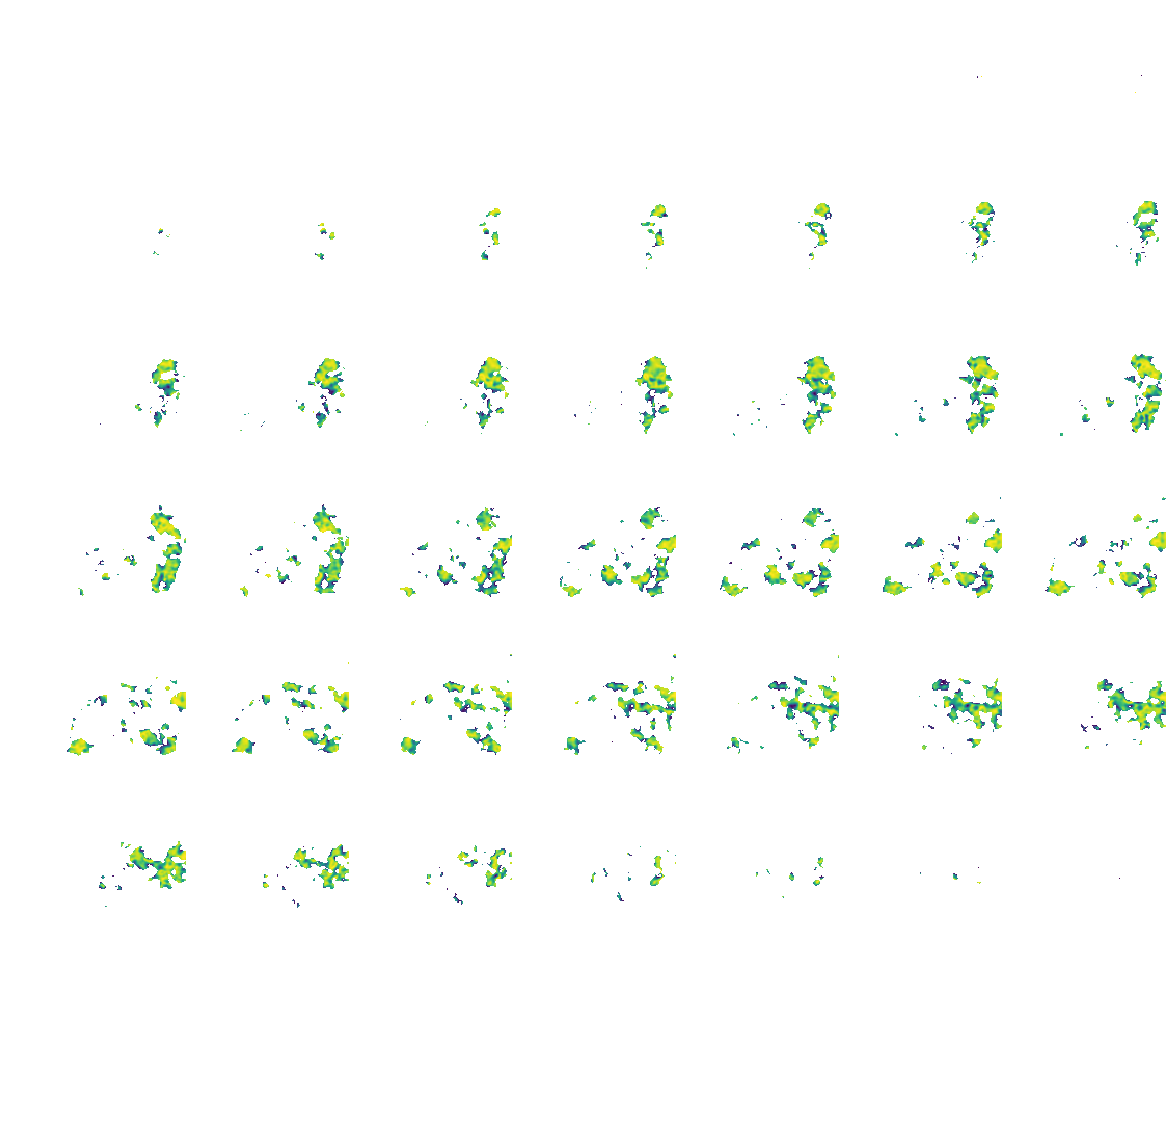

In [54]:
corrs__ = corrs_.copy()
corrs__[np.where(corrs_<.7)]=np.nan
corrs__[np.where(np.moveaxis(right_maxs,-1,0)<.0015)] = np.nan
corrs__[np.where(np.moveaxis(left_maxs,-1,0)<.0015)] = np.nan


plt.figure(figsize=(20,20))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.imshow(corrs__[i,:,:].T)
    plt.axis('off')

In [44]:
corrs__ = np.moveaxis(corrs_,0,-1)
corrs__.shape

(128, 128, 49)

In [45]:
corrs__.shape, right_maxs.shape, left_maxs.shape

((128, 128, 49), (128, 128, 49), (128, 128, 49))

In [31]:
mask_hemi = np.ones((128,128,49))
mask_hemi[np.where(corrs__<.5)]= 0
mask_hemi[np.where(right_maxs<.0004)] = 0
mask_hemi[np.where(left_maxs<.0004)] = 0
mask = np.concatenate((mask_hemi, mask_hemi[::-1,:,:]), axis=0)
mask.shape

(256, 128, 49)

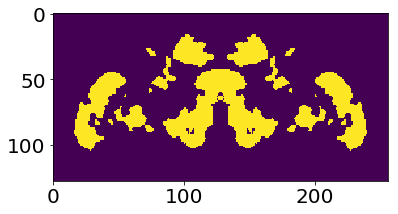

In [32]:
plt.imshow(mask[:,:,25].T)

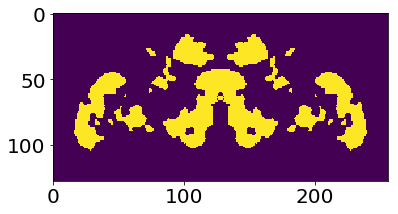

In [25]:
plt.imshow(mask[:,:,25].T)

In [33]:
### avg signals from left and right
LR_mean_hemi = np.mean(np.array([left,right]), axis=0)
LR_mean_hemi.shape
LR_mean = np.concatenate((LR_mean_hemi, LR_mean_hemi[::-1,:,:]), axis=0)
LR_mean.shape

(256, 128, 49, 50)

In [34]:
### mask
LR_mean_masked = LR_mean * mask[...,np.newaxis]
LR_mean_masked.shape

(256, 128, 49, 50)

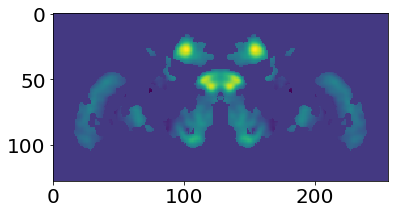

In [35]:
plt.imshow(LR_mean_masked[:,:,25,25].T)

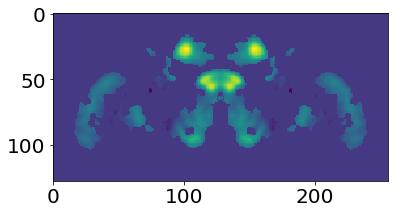

In [28]:
plt.imshow(LR_mean_masked[:,:,25,25].T)

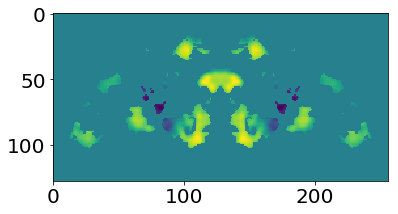

In [59]:
plt.imshow(LR_mean_masked[:,:,25,15].T)

In [37]:
### need list of non-masked signals for clustering
signals = np.reshape(LR_mean_masked,(256*128*49,50))
sums = np.sum(signals,axis=-1)
to_delete = np.where(sums==0)[0]
signals_for_clustering = np.delete(signals, to_delete,axis=0)
### normalize
maxs = np.max(np.abs(signals_for_clustering),axis=-1)
signals_for_clustering = signals_for_clustering/maxs[:,np.newaxis]
signals_for_clustering.shape

(128596, 50)

# smooth but no mirror

In [11]:
maps = maps.numpy()

In [12]:
maps.shape

(256, 128, 49, 50)

In [13]:
maps_smo = gaussian_filter(maps,sigma=2,truncate=1)

In [14]:
maxs = np.max(np.abs(maps_smo),axis=-1)
maxs.shape

(256, 128, 49)

In [15]:
maps_smo_ = maps_smo.copy()
maps_smo_[np.where(maxs<0.00055)] = 0

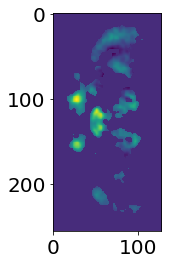

In [16]:
plt.imshow(maps_smo_[:,:,25,25])

In [17]:
### need list of non-masked signals for clustering
signals = np.reshape(maps_smo_,(256*128*49,50))
sums = np.sum(signals,axis=-1)
to_delete = np.where(sums==0)[0]
signals_for_clustering = np.delete(signals, to_delete,axis=0)
### normalize
maxs = np.max(np.abs(signals_for_clustering),axis=-1)
signals_for_clustering = signals_for_clustering/maxs[:,np.newaxis]
signals_for_clustering.shape

(114529, 50)

# Clustering

In [ ]:
t0 = time.time()
clustering_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/clustering'
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=clustering_dir,
                                linkage='ward')
model = model.fit(signals_for_clustering)
print('complete!')
print(time.time()-t0)

clustering.........


In [62]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [63]:
###############
n_clusters = 10
###############

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.jet(np.linspace(0, 1, n_clusters))
cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors)

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

In [64]:
### mean cluster responses
cluster_responses = []
for n in np.unique(cluster_ids):
    cluster_response = np.mean(signals_for_clustering[cluster_ids==n,:], axis=0)
    cluster_responses.append(cluster_response)
    
cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

add_deleted_voxels = np.zeros(49*128*256)
#add_deleted_voxels[:] = np.nan #<---------
to_replace = np.where(sums!=0)[0]

In [65]:
# ### to display only some clusters:
# to_keep = np.concatenate((np.where(cluster_ids==8)[0], np.where(cluster_ids==14)[0]))
# to_zero = [i for i in range(len(cluster_ids)) if i not in to_keep]
# cluster_ids = cluster_ids.astype('float64')
# cluster_ids[to_zero] = np.nan
# #####

add_deleted_voxels[to_replace] = cluster_ids #model.labels_ ### put signal here

add_deleted_voxels[to_delete] = np.nan #<------


to_plot = np.reshape(add_deleted_voxels, (256,128,49))

# now lets look at the brain with these clusters

# all_colored_by_betas = []
# for z in range(49):
#     colored_by_betas = np.zeros(256*128)
#     for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
#         cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
#         colored_by_betas[cluster_indicies] = to_plot[z,cluster_num]
#     colored_by_betas = colored_by_betas.reshape(256,128)
#     all_colored_by_betas.append(colored_by_betas)
# all_colored_by_betas = np.asarray(all_colored_by_betas)
# to_plot = np.max(all_colored_by_betas, axis=0)
# plt.imshow(to_plot[:,:].T)
#all_colored_by_betas[all_colored_by_betas==0] = np.nan

In [252]:
cluster_ids.astype('float64')

array([0., 0., 0., ..., 0., 0., 0.])

In [234]:
len(np.where(cluster_ids==7)[0]), len(np.where(cluster_ids==13)[0])

(4476, 6560)

In [239]:
len()

11036

In [235]:
len(np.logical_and(np.where(cluster_ids==7)[0], np.where(cluster_ids==13)[0]))

ValueError: operands could not be broadcast together with shapes (4476,) (6560,) 

In [67]:
to_plot[80,55,31]

1.0

In [88]:
to_plot[:,:,15]

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

In [80]:
np.unique(to_plot[:,:,-8])

array([4., 5.])

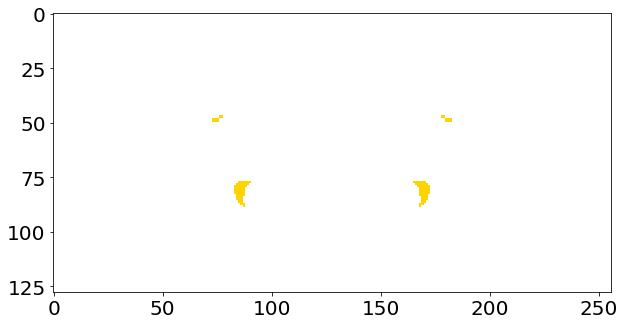

In [268]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot[:,:,27].T,cmap=cmap,vmin=1,vmax=n_clusters)

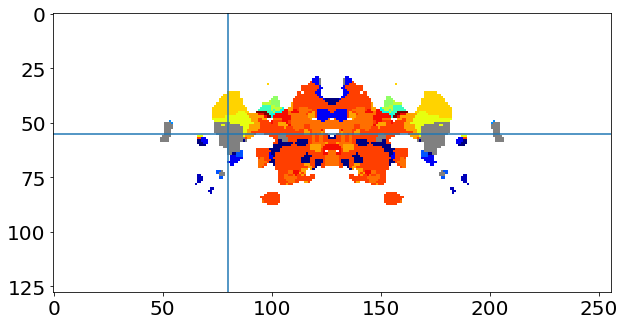

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot[:,:,36].T,cmap=cmap)
plt.axhline(55)
plt.axvline(80)

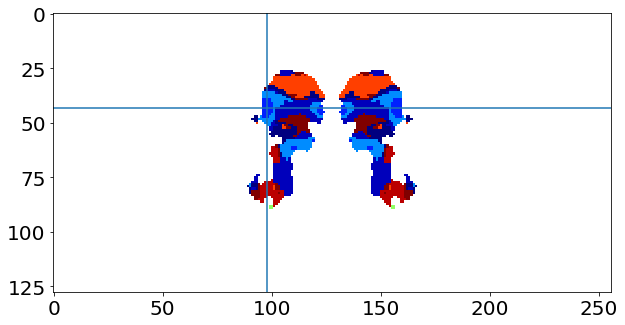

In [149]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot[:,:,14].T,cmap=cmap)
plt.axhline(43)
plt.axvline(98)

In [153]:
np.unique(np.nan_to_num(to_plot[:,:,14]))

array([ 0.,  9., 10., 11., 12., 15., 18., 19., 20.])

In [154]:
np.unique(np.nan_to_num(to_plot[:,:,15]))

array([ 0.,  2.,  6.,  9., 10., 11., 12., 13., 14., 15., 16., 18., 19.,
       20.])

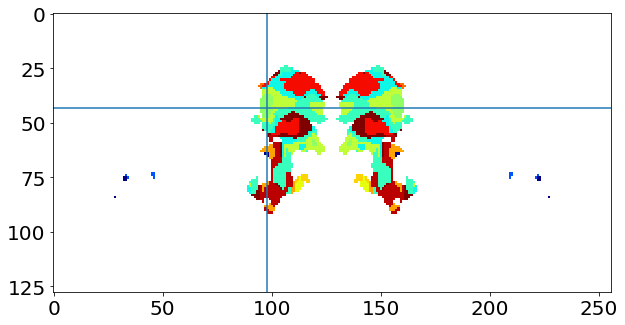

In [150]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot[:,:,15].T,cmap=cmap)
plt.axhline(43)
plt.axvline(98)

In [151]:
to_plot[98,43,14], to_plot[98,43,15]

(11.0, 11.0)

In [144]:
to_plot[110,33,14], to_plot[110,33,15]

(18.0, 18.0)

In [125]:
to_plot[110,42,15]

12.0

In [124]:
to_plot[110,42,14]

10.0

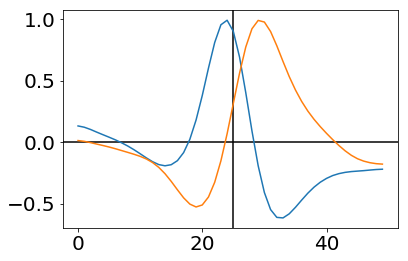

In [227]:
plt.axvline(25,color='k')
plt.axhline(0,color='k')
plt.plot(cluster_responses[10])
plt.plot(cluster_responses[12])

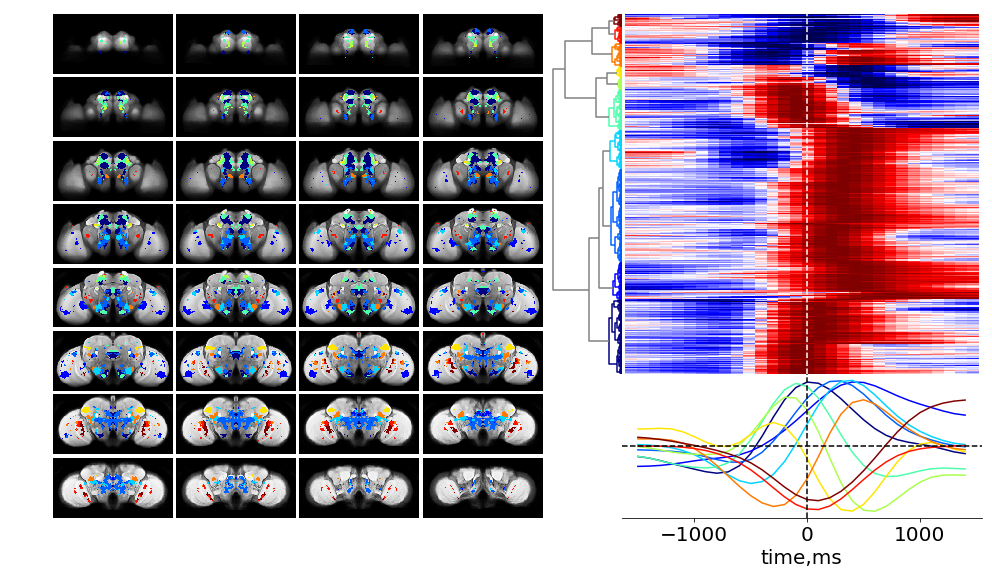

In [69]:
fig = plt.figure(figsize=(10,10))

### dendrogram ###
ax_dendrogram = fig.add_axes([1, .3, .1, .5])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

### all resp ###
ax_dend = fig.add_axes([1.1, .3, .5, .5])
ax_dend.imshow(signals_for_clustering[dend['leaves'][::-1],:],vmin=-1,vmax=1,aspect=0.0004,cmap='seismic')
ax_dend.axis('off')
for line in [15]:
    ax_dend.axvline(line,color='w',linestyle='--')    
#plt.title('top 25% fwd, ward, normalized')

### Mean resp ###
ax = fig.add_axes([1.1, 0.1, .5, .2])
timepoints = list(range(-1500,0,100)) + list(range(0,1500,100))
for n in range(len(np.unique(cluster_ids))):
    ax.plot(timepoints, cluster_responses[n],color=cluster_colors[n])
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.set_xlabel('time,ms')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### BRAIN ###
grid = ImageGrid(fig, rect=[.3,.1,.7,.7], nrows_ncols=(8, 4), axes_pad=.05)
for j,i in enumerate(range(8,49-9)):
    grid[j].imshow(luke.numpy()[:,:,i].T,cmap='gray')
    cax = grid[j].imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
for i in range(32):
    grid[i].axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_fwd_noreg')
plt.savefig(fname,dpi=300,bbox_inches='tight')

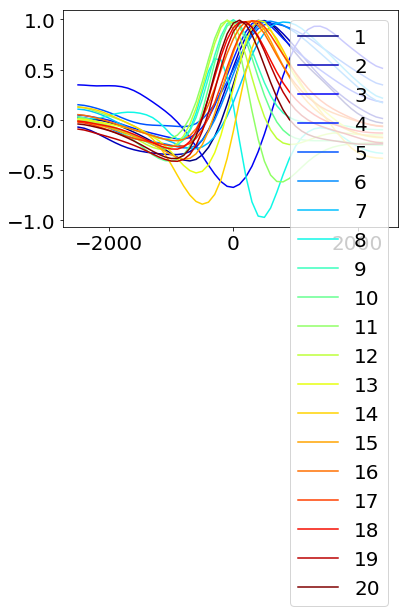

In [266]:
for n in range(len(np.unique(cluster_ids))):
    plt.plot(timepoints, cluster_responses[n],color=cluster_colors[n],label=n+1)
plt.legend()

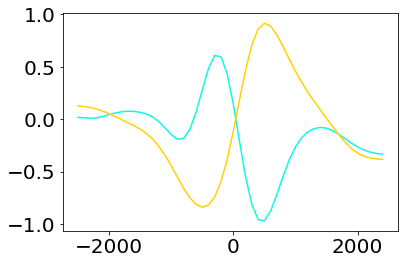

In [231]:
n=7
plt.plot(timepoints, cluster_responses[n],color=cluster_colors[n],label=n)
n=13
plt.plot(timepoints, cluster_responses[n],color=cluster_colors[n],label=n)

In [202]:
for j,i in enumerate(range(8,49-8)):
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


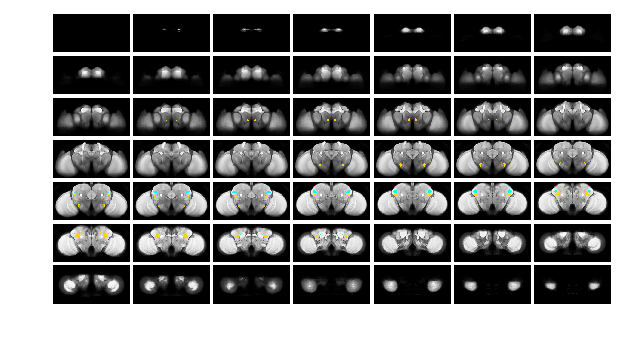

In [270]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(luke.numpy()[:,:,i].T,cmap='gray')
    cax = grid[i].imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
    grid[i].axis('off')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

100%|██████████| 20/20 [01:52<00:00,  5.69s/it]


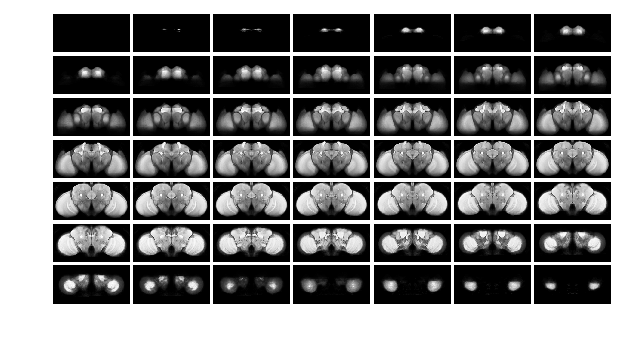

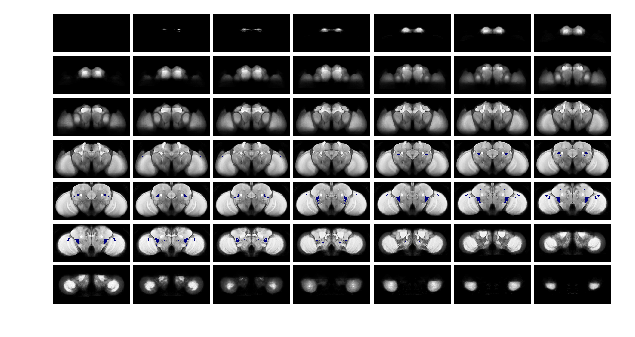

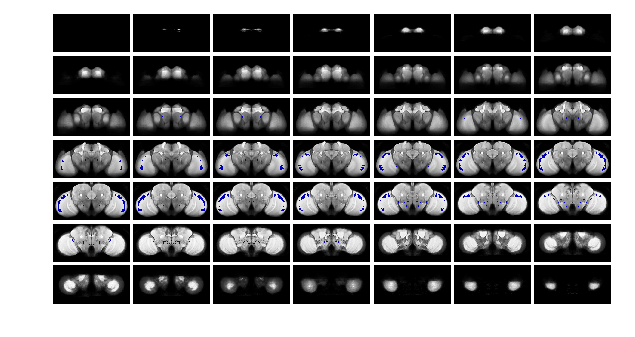

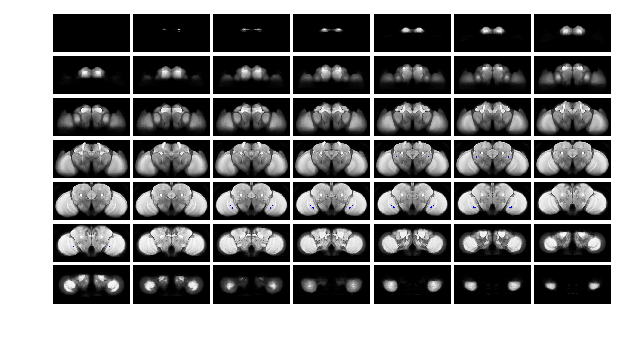

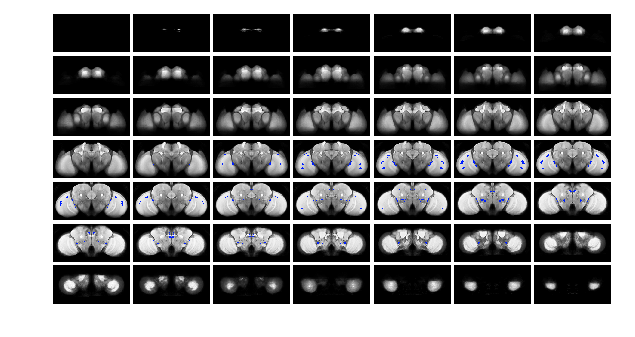

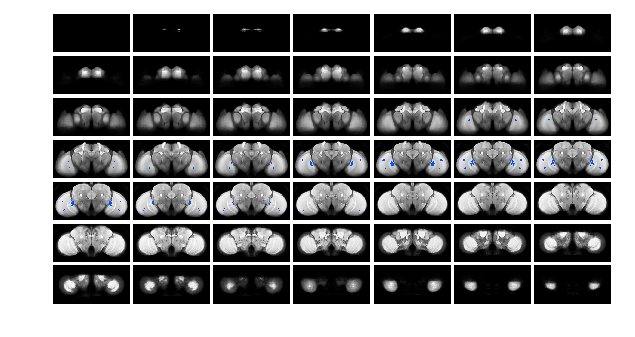

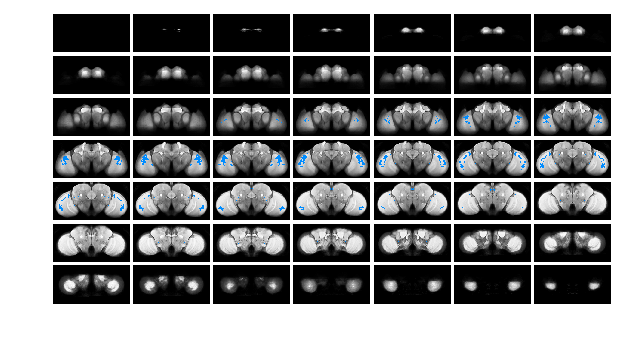

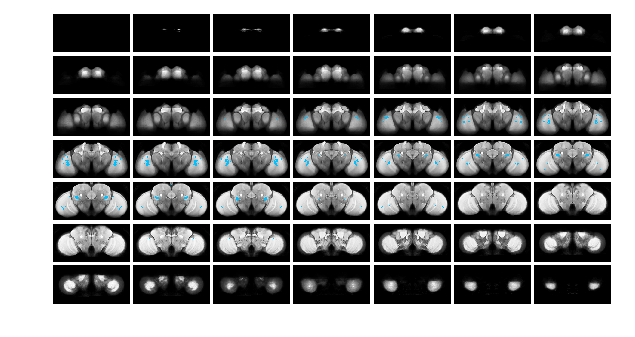

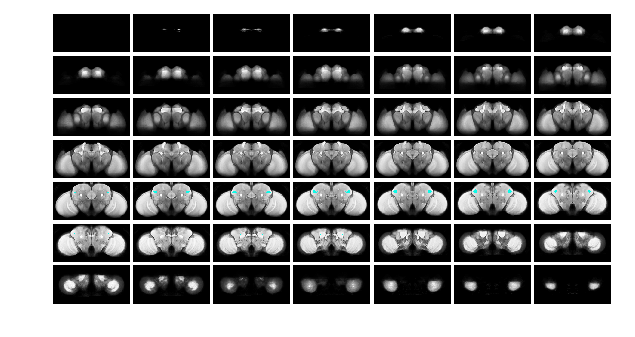

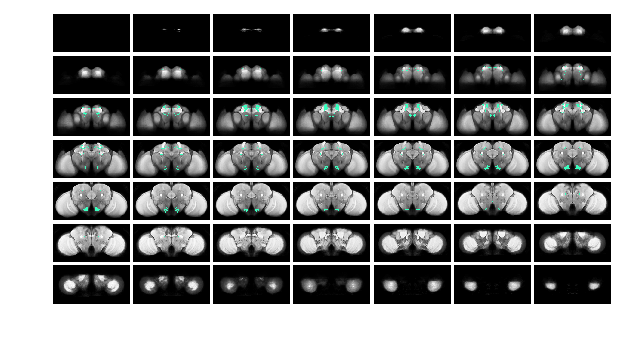

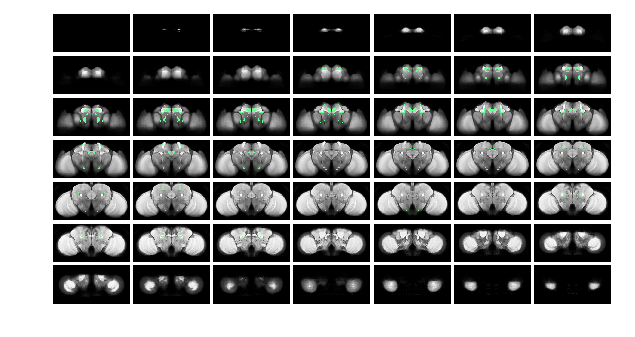

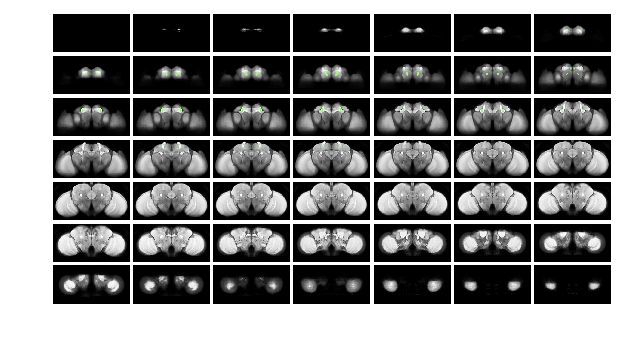

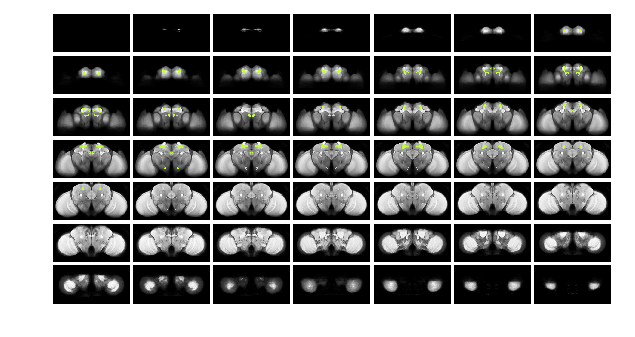

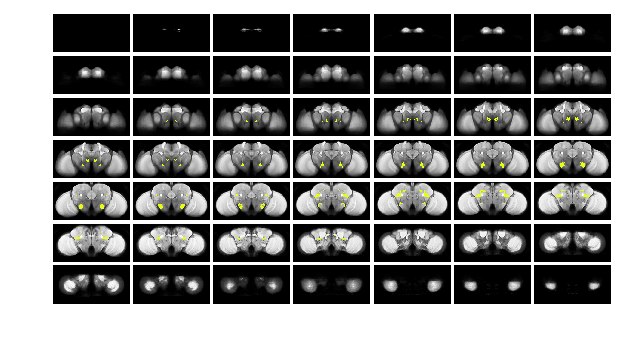

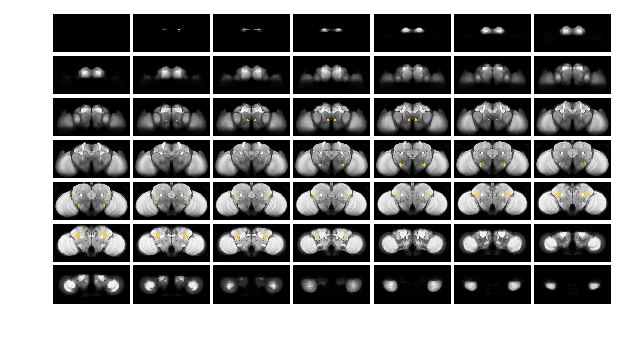

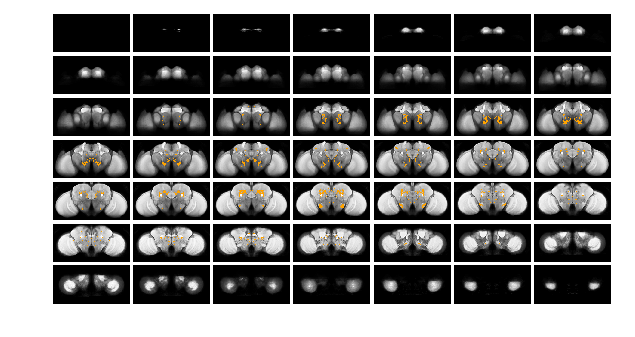

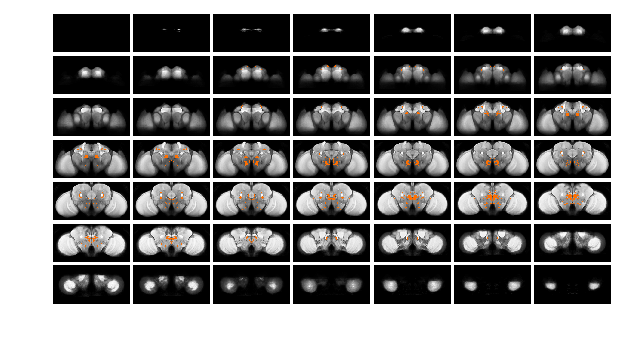

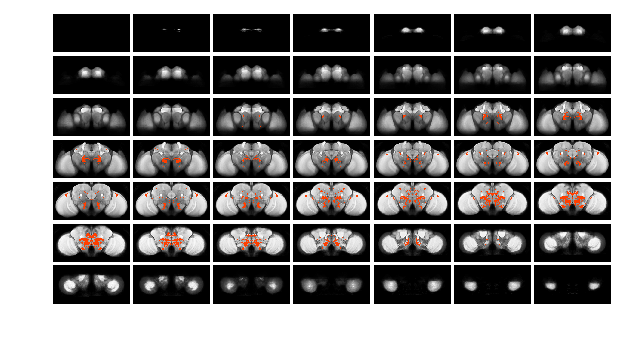

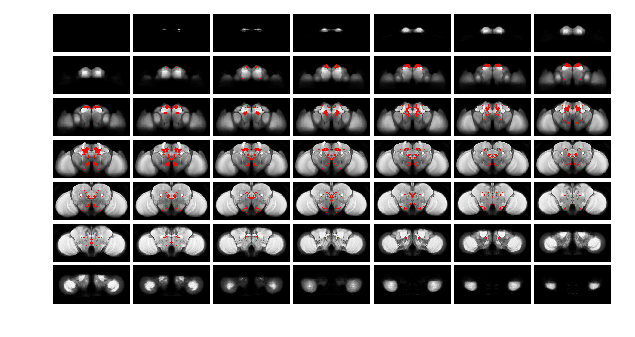

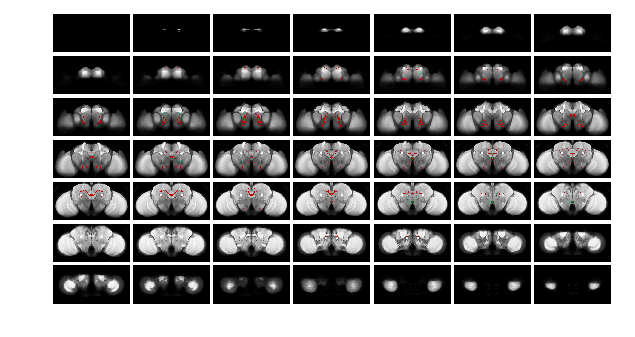

In [281]:
for clu in tqdm(range(20)):
    ### to display only some clusters:
    to_keep = np.where(cluster_ids==clu)[0]
    to_zero = [i for i in range(len(cluster_ids)) if i not in to_keep]
    cluster_ids_for_singles = cluster_ids.astype('float64')
    cluster_ids_for_singles[to_zero] = np.nan
    add_deleted_voxels[to_replace] = cluster_ids_for_singles
    add_deleted_voxels[to_delete] = np.nan
    to_plot = np.reshape(add_deleted_voxels, (256,128,49))

    fig = plt.figure(figsize=(10,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
    for i in range(49):
        grid[i].imshow(luke.numpy()[:,:,i].T,cmap='gray')
        cax = grid[i].imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
        grid[i].axis('off')
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210616_video_3'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [280]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210616_video_3'
os.mkdir(save_path)

In [67]:
to_plot[np.where(to_plot==0)]=np.nan

100%|██████████| 33/33 [00:45<00:00,  2.52s/it]


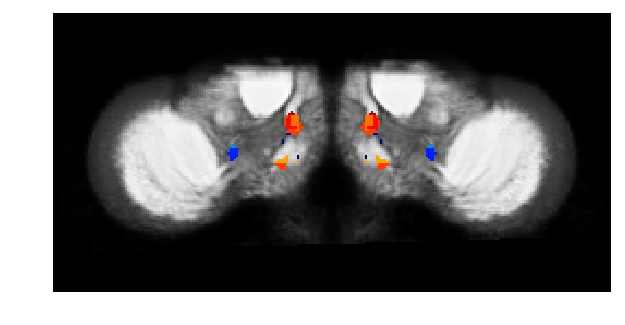

In [199]:
plt.figure(figsize=(10,10))
for i in tqdm(range(8,49-8)):
    plt.imshow(luke.numpy()[:,:,i].T,cmap='gray')
    plt.imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
    plt.axis('off')
    label = format(i, '02d')
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210616_video_2'
    fname = os.path.join(save_path, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')

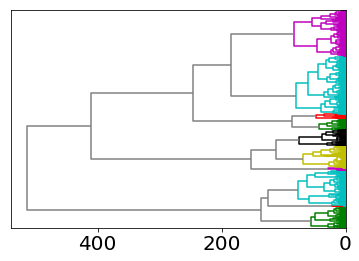

In [30]:
n_clusters=10
thresh = model.distances_[-n_clusters+1]
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

In [198]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210616_video_2'
os.mkdir(save_path)

In [77]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210614_clusters_to_rotate.npy'
to_rotate = np.load(load_file)
to_rotate = np.moveaxis(to_rotate,0,-1)
to_rotate = to_rotate[:,:,::-1]
to_rotate.shape

(256, 128, 49)

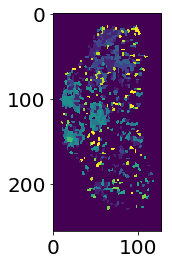

In [62]:
plt.imshow(to_rotate[:,:,20])

In [78]:
res_LUKE = (2.6, 2.6, 5)
moving = ants.from_numpy(to_rotate)
moving.set_spacing(res_LUKE)

In [79]:
maps = ants.apply_transforms(fixed, moving, affine_file, interpolator='nearestNeighbor')

In [80]:
maps.shape

(256, 128, 49)

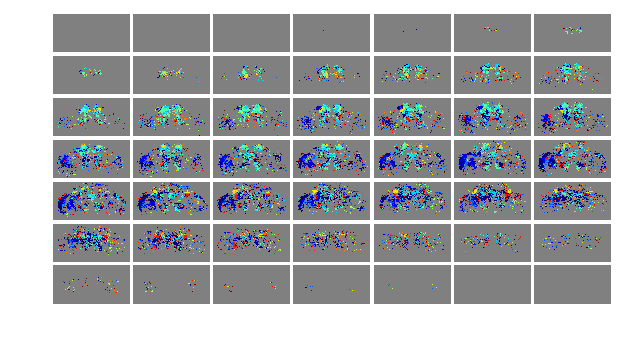

In [81]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(maps[:,:,i].T,cmap=cmap);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

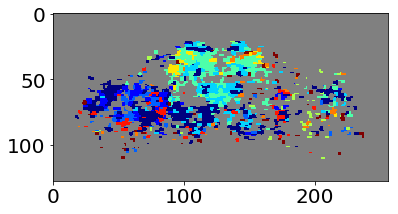

In [72]:
plt.imshow(maps[:,:,20].T,cmap=cmap)

In [ ]:
fwd = np.concatenate((mean_masked, mean_masked[::-1,:,:]), axis=0)


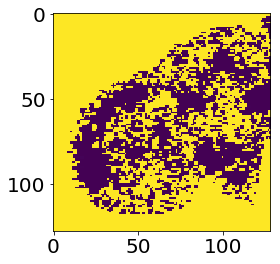

In [109]:
sigs__ = sigs_.copy()
sigs__[np.where(sigs_>.01)]=1
plt.imshow(sigs__[27,:,:].T)

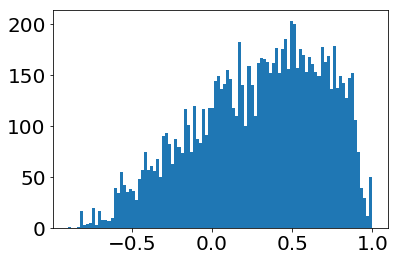

In [96]:
plt.hist(corrs_[27,:,:].flatten(),bins=100);

In [209]:
left = maps.numpy()[:128,:,:,2]
right = maps.numpy()[128:,:,:,2]

right = right[::-1,:,:]

In [210]:
mask = np.logical_and(right!=0, left!=0)
mask.shape

(128, 128, 49)

In [211]:
LR_mean = np.mean(np.array([left,right]), axis=0)

In [212]:
mean_masked = LR_mean*mask

In [213]:
mask_xor = np.logical_xor(right!=0, left!=0)

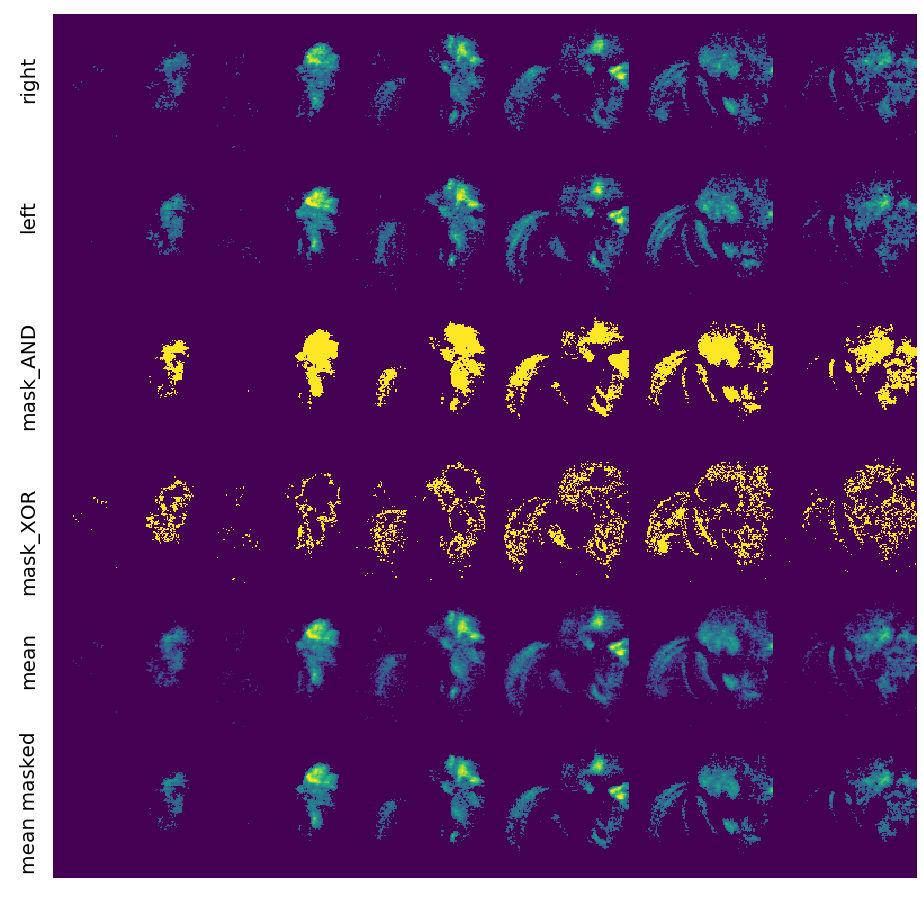

In [217]:
fig = plt.figure(figsize=(10,10))
for i,z in enumerate([10,15,20,25,30,35]):
    ax = fig.add_axes([0+(.2*i),1,.2,.2])
    ax.imshow(right[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='right',x=-30,y=50,rotation=90)
    
    ax = fig.add_axes([0+(.2*i),.8,.2,.2])
    ax.imshow(left[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='left',x=-30,y=50,rotation=90)
    
    ax = fig.add_axes([0+(.2*i),.6,.2,.2])
    ax.imshow(mask[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_AND',x=-30,y=30,rotation=90)
    
    ax = fig.add_axes([0+(.2*i),.4,.2,.2])
    ax.imshow(mask_xor[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_XOR',x=-30,y=50,rotation=90)
    
    ax = fig.add_axes([0+(.2*i),.2,.2,.2])
    ax.imshow(LR_mean[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mean',x=-30,y=50,rotation=90)
        
    ax = fig.add_axes([0+(.2*i),0,.2,.2])
    ax.imshow(mean_masked[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mean masked',x=-30,y=10,rotation=90)
        
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [164]:
left_all = maps.numpy()[:128,:,:,2]
right_all = maps.numpy()[128:,:,:,2]

right_all = right_all[::-1,:,:]

In [122]:
left.shape

(128, 128, 49)

In [123]:
right.shape

(128, 128, 49)

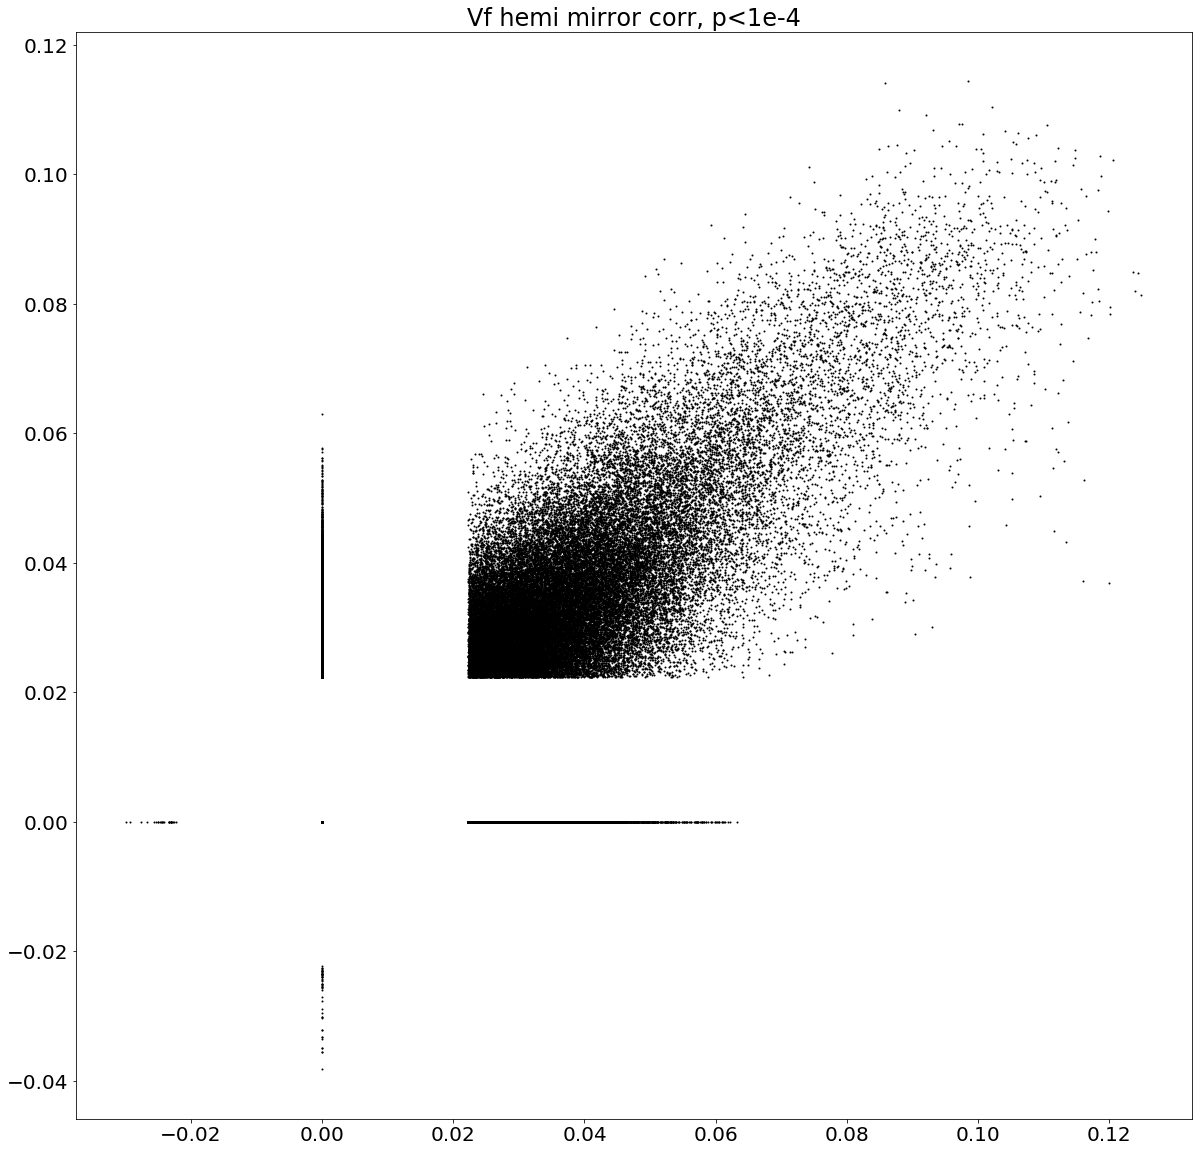

In [193]:
plt.figure(figsize=(20,20))
plt.plot(left.flatten(), right.flatten(),'o',markersize=1,color='k')

#plt.plot(left.flatten(), right.flatten(),'o',markersize=1,color='k')
plt.title('Vf hemi mirror corr, p<1e-4')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'Vf hemi corr')

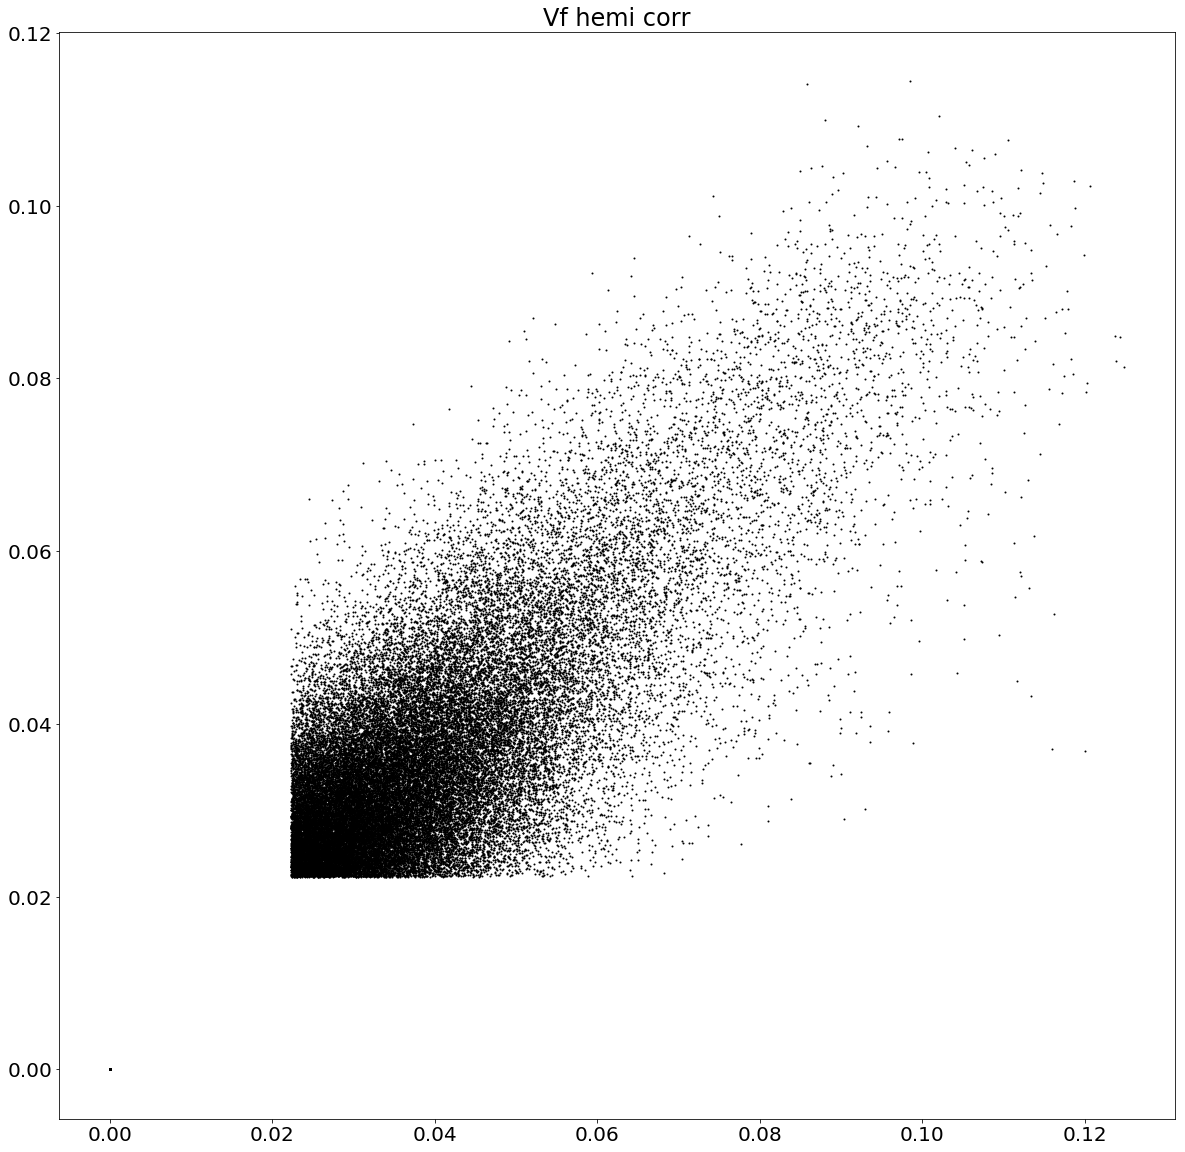

In [169]:
plt.figure(figsize=(20,20))
plt.plot((left*mask).flatten(), (right*mask).flatten(),'o',markersize=1,color='k')
plt.title('Vf hemi corr')

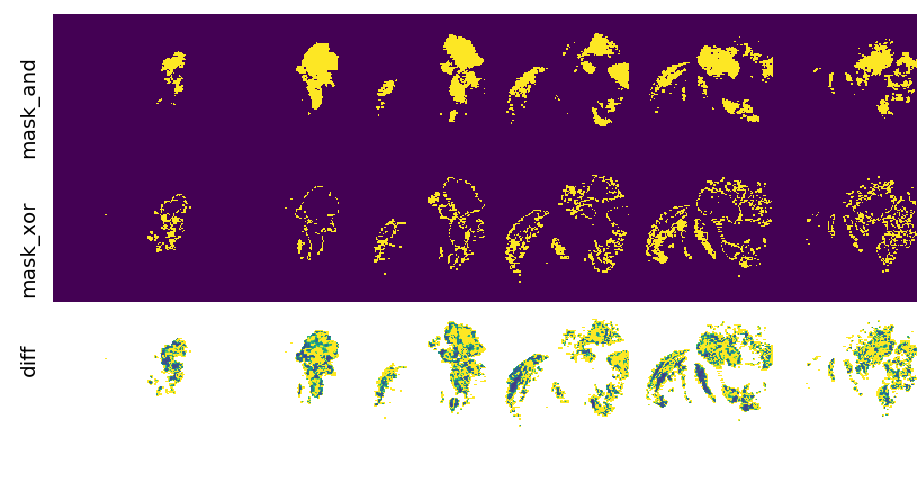

In [153]:
fig = plt.figure(figsize=(10,10))
for i,z in enumerate([10,15,20,25,30,35]):
    ax = fig.add_axes([0+(.2*i),1,.2,.2])
    ax.imshow(mask[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_and',x=-30,y=50,rotation=90)
    
    ax = fig.add_axes([0+(.2*i),.8,.2,.2])
    ax.imshow(mask_xor[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_xor',x=-30,y=50,rotation=90)
        
    ax = fig.add_axes([0+(.2*i),.6,.2,.2])
    ax.imshow(1/np.abs(left[:,:,z].T-right[:,:,z].T),vmin=0,vmax=100)
    ax.axis('off')
    if i == 0:
        plt.text(s='diff',x=-30,y=50,rotation=90)
        
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [71]:
num_agree_pix = np.sum(mask.flatten())
num_disagree_pix = np.sum(mask_xor.flatten())

In [72]:
num_agree_pix

83493

In [73]:
num_disagree_pix

44419

In [27]:
left[left==0] = np.nan
right[right==0] = np.nan

In [201]:
r, p = scipy.stats.pearsonr(left.flatten(), right.flatten())
r

0.61385494

In [107]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/left.nii"
nib.Nifti1Image(left, np.eye(4)).to_filename(save_file)

save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/right.nii"
nib.Nifti1Image(right, np.eye(4)).to_filename(save_file)

In [108]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/lr_mean.nii"
nib.Nifti1Image(LR_mean, np.eye(4)).to_filename(save_file)

# L/R turn analysis

In [222]:
left = maps.numpy()[::,:,:,0]
right = maps.numpy()[::-1,:,:,1]

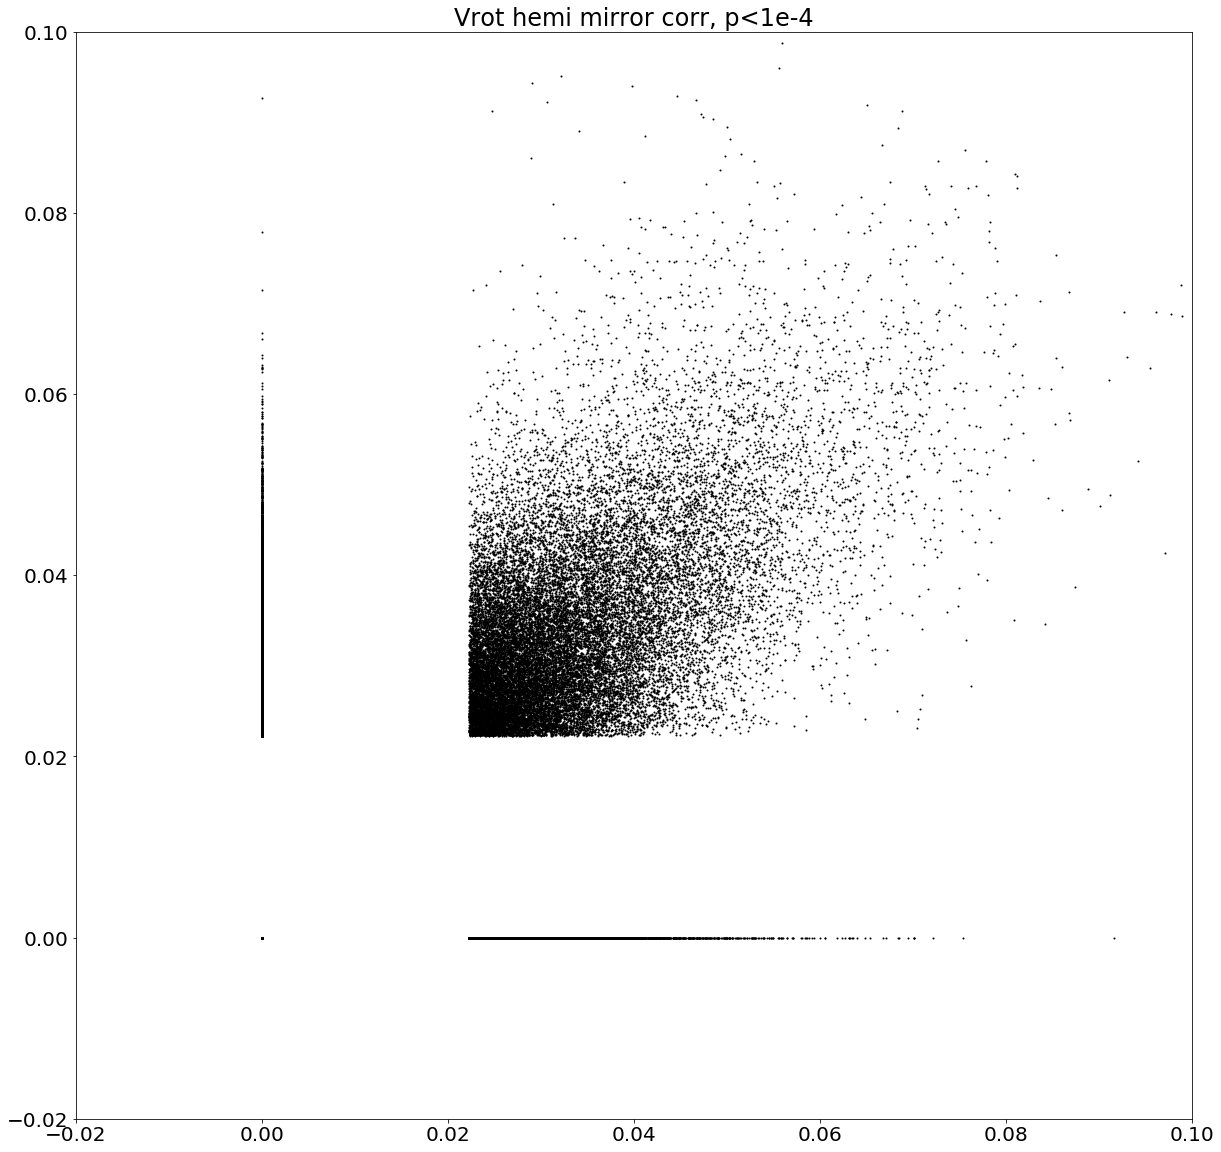

In [203]:
plt.figure(figsize=(20,20))
plt.plot(left.flatten(), right.flatten(),'o',markersize=1,color='k')
plt.ylim(-.02,.1)
plt.xlim(-.02,.1)

#plt.plot(left.flatten(), right.flatten(),'o',markersize=1,color='k')
plt.title('Vrot hemi mirror corr, p<1e-4')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [223]:
mask = np.logical_and(right!=0, left!=0)
mask.shape

(256, 128, 49)

In [224]:
mask_xor = np.logical_xor(right!=0, left!=0)

In [225]:
LR_mean = np.mean(np.array([left,right]), axis=0)

In [226]:
mean_masked = LR_mean*mask

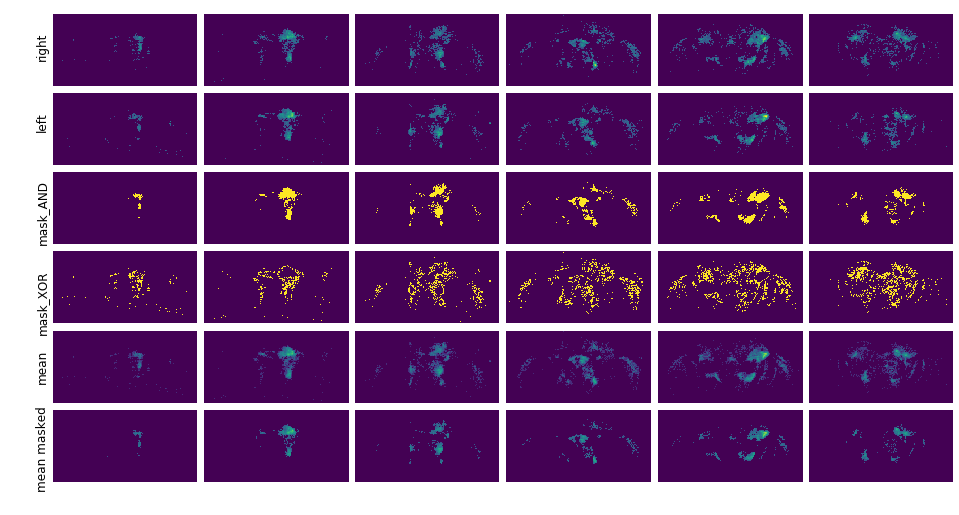

In [230]:
fig = plt.figure(figsize=(10,10))
for i,z in enumerate([10,15,20,25,30,35]):
    ax = fig.add_axes([0+(.21*i),1,.2,.2])
    ax.imshow(right[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='right',x=-30,y=50,rotation=90,fontsize=12)
    
    ax = fig.add_axes([0+(.21*i),.89,.2,.2])
    ax.imshow(left[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='left',x=-30,y=50,rotation=90,fontsize=12)
    
    ax = fig.add_axes([0+(.21*i),.78,.2,.2])
    ax.imshow(mask[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_AND',x=-30,y=30,rotation=90,fontsize=12)
    
    ax = fig.add_axes([0+(.21*i),.67,.2,.2])
    ax.imshow(mask_xor[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_XOR',x=-30,y=50,rotation=90,fontsize=12)
    
    ax = fig.add_axes([0+(.21*i),.56,.2,.2])
    ax.imshow(LR_mean[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mean',x=-30,y=50,rotation=90,fontsize=12)
        
    ax = fig.add_axes([0+(.21*i),.45,.2,.2])
    ax.imshow(mean_masked[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mean masked',x=-30,y=10,rotation=90,fontsize=12)
        
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [45]:
mask_xor = np.logical_xor(right!=0, left!=0)

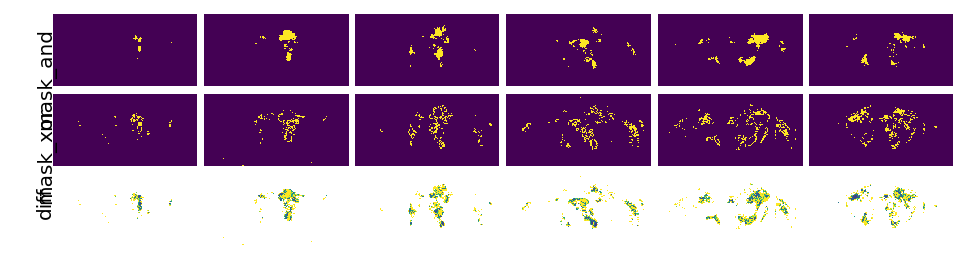

In [49]:
fig = plt.figure(figsize=(10,10))
for i,z in enumerate([10,15,20,25,30,35]):
    ax = fig.add_axes([0+(.21*i),1,.2,.2])
    ax.imshow(mask[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_and',x=-30,y=50,rotation=90)
    
    ax = fig.add_axes([0+(.21*i),.89,.2,.2])
    ax.imshow(mask_xor[:,:,z].T,vmin=0,vmax=.1)
    ax.axis('off')
    if i == 0:
        plt.text(s='mask_xor',x=-30,y=50,rotation=90)
        
    ax = fig.add_axes([0+(.21*i),.78,.2,.2])
    ax.imshow(1/np.abs(left[:,:,z].T-right[:,:,z].T),vmin=0,vmax=100)
    ax.axis('off')
    if i == 0:
        plt.text(s='diff',x=-30,y=50,rotation=90)
        
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

# make corr map with eroded mirrors

In [18]:
norm_min = 0
#norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 0.1#0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing(res_LUKE)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [19]:
maps = ants.apply_transforms(fixed, moving, affine_file, imagetype=3, interpolator='nearestNeighbor')

In [20]:
maps.shape

(256, 128, 49, 3)

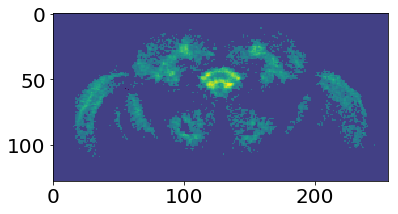

In [21]:
plt.imshow(maps.numpy()[:,:,27,2].T)

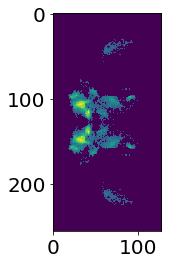

In [22]:
### Forward ###

left = maps.numpy()[:128,:,:,2]
right = maps.numpy()[128:,:,:,2]

right = right[::-1,:,:]

mask = np.logical_and(right!=0, left!=0)
mask.shape

LR_mean = np.mean(np.array([left,right]), axis=0)

mean_masked = LR_mean*mask

fwd = np.concatenate((mean_masked, mean_masked[::-1,:,:]), axis=0)

plt.imshow(fwd[:,:,20])

In [23]:
### Rotation ###

left = maps.numpy()[::,:,:,0]
right = maps.numpy()[::-1,:,:,1]

mask = np.logical_and(right!=0, left!=0)
mask.shape

LR_mean = np.mean(np.array([left,right]), axis=0)

mean_masked = LR_mean*mask

rot = mean_masked

In [24]:
### combine back into color channels ###

mirrored_clean = np.concatenate((rot[::-1,:,:,np.newaxis], rot[...,np.newaxis], fwd[...,np.newaxis]),axis=-1)


In [25]:
mirrored_clean.shape

(256, 128, 49, 3)

In [28]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/final2.nii"
nib.Nifti1Image(mirrored_clean, np.eye(4)).to_filename(save_file)

In [27]:
mirrored_clean = np.swapaxes(mirrored_clean, 2, 3)

In [13]:
mirrored_clean.shape

(128, 256, 49, 3)

In [16]:
func_iso = ants.resample_image(ants.from_numpy(mirrored_clean),(int(512*0.65), int(1024*0.65), int(256*1),1,1,)).numpy()

RuntimeError: /home/users/brezovec/ANTsPy/itksource/Modules/Core/Common/include/itkMatrix.h:256:
itk::ERROR: Singular matrix. Determinant is 0.

In [14]:
func_iso = ants.resample_image(ants.from_numpy(mirrored_clean[:,:,:,:]),(int(512*0.65), int(1024*0.65), int(256*1), 3),1,1,).numpy()

In [15]:
func_iso.shape

(332, 665, 256, 3)

In [16]:
plt.imshow(out[:,:,130])

NameError: name 'out' is not defined

In [32]:
out = gaussian_filter(func_iso[:,:,:,0],sigma=4)

In [34]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/20210504_mirror_clean_iso_turn_gauss.nii"
nib.Nifti1Image(out, np.eye(4)).to_filename(save_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

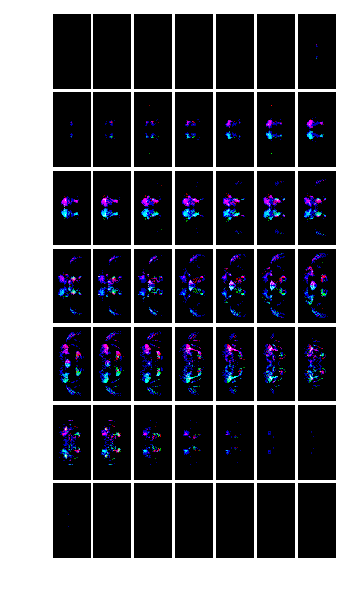

In [17]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(np.swapaxes(mirrored_clean[:,:,i,:]*2,0,1));
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')